# Genie: 蛋白质从头设计演示 (De Novo Protein Design Demo)

本笔记演示了 Genie 模型的完整流程：从训练到采样再到评估。
This notebook demonstrates the complete workflow of the Genie model: from training to sampling and evaluation.

In [7]:
import os
import sys
import glob
import shutil
import torch
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# Add current directory to path
sys.path.append(os.getcwd())

from genie.config import Config
from genie.utils.model_io import load_model

# Check GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## 2. 训练 (Training)

如果你想从头训练一个新模型，可以使用 `genie/train.py`。
If you want to train a new model from scratch, you can use `genie/train.py`.

训练过程通常需要你自行在终端运行，因为它涉及到分布式训练（多GPU）和长时间运行。
Training is typically run in a terminal as it involves distributed training (multi-GPU) and long runtimes.

**命令行参数说明（相当于 `--help`）：**

- `-c, --config`（必选 / required）：配置文件路径或名称（用于指定模型与训练超参数）。
- `-g, --gpus`（可选 / optional）：使用的 GPU 设备，例如 `"0"` 或 `"0,1"`。
- `-r, --resume`（可选 / optional）：断点续训 checkpoint（`.ckpt`）文件路径。

以下是启动训练的命令示例：
Here is an example command to start training:

### 数据集准备 (Dataset Preparation)

在开始训练之前，必须先下载并处理 SCOPe 数据集。提供了一个自动化脚本来完成此任务。
Before training, you must download and process the SCOPe dataset. We provide an automated script for this task.

In [ ]:
# Run dataset installation script
!bash scripts/install_dataset.sh

In [ ]:
#To train a new model (Command to run in terminal):
!python genie/train.py --config example_configuration --gpus 0,1

# 配置文件定义了超参数。详情请查看 genie/config.py
# Configuration files define hyperparameters. See genie/config.py for details.

## 3. 准备预训练权重 (Prepare Pre-trained Weights)

如果你不进行训练，而是使用提供的预训练权重进行采样，请继续此步骤。
If you are skipping training and using provided pre-trained weights for sampling, proceed with this step.

提供的权重文件结构是扁平的。采样脚本需要特定的目录层级 (`runs/<model_name>/version_<X>/checkpoints/`)。我们将创建一个临时的 `runs` 目录并正确链接权重。
The provided weights are in a flat structure. The sampling script expects a specific directory hierarchy (`runs/<model_name>/version_<X>/checkpoints/`). We will create a temporary `runs` directory and link the weights correctly.

In [9]:
def setup_weights(source_path, model_name, target_root='runs', version=0):
    """
    Restructures weights from source_path to target_root compatible with Genie's loader.
    """
    
    # Target paths
    run_dir = os.path.join(target_root, model_name)
    version_dir = os.path.join(run_dir, f'version_{version}')
    ckpt_dir = os.path.join(version_dir, 'checkpoints')
    
    # Create directories
    os.makedirs(ckpt_dir, exist_ok=True)
    
    # 1. Copy/Link Configuration
    src_config = os.path.join(source_path, 'configuration')
    dst_config = os.path.join(run_dir, 'configuration')
    if os.path.exists(src_config) and not os.path.exists(dst_config):
        shutil.copy(src_config, dst_config)
        print(f"Copied configuration to {dst_config}")
        
    # 2. Link Checkpoint
    # Find .ckpt file in source
    ckpts = glob.glob(os.path.join(source_path, '*.ckpt'))
    if not ckpts:
        raise FileNotFoundError(f"No .ckpt files found in {source_path}")
    
    src_ckpt = ckpts[0] # Take the first one found
    ckpt_name = os.path.basename(src_ckpt)
    dst_ckpt = os.path.join(ckpt_dir, ckpt_name)
    
    if not os.path.exists(dst_ckpt):
        # Use symlink if possible, else copy
        try:
            os.symlink(os.path.abspath(src_ckpt), dst_ckpt)
            print(f"Symlinked checkpoint to {dst_ckpt}")
        except OSError:
            shutil.copy(src_ckpt, dst_ckpt)
            print(f"Copied checkpoint to {dst_ckpt}")

# Define model to use
MODEL_NAME = 'scope_l_128'
WEIGHTS_PATH = os.path.join('weights', MODEL_NAME)

# Set up the folder structure
setup_weights(WEIGHTS_PATH, MODEL_NAME)

Copied configuration to runs/scope_l_128/configuration
Symlinked checkpoint to runs/scope_l_128/version_0/checkpoints/epoch=49999.ckpt


### 权重整理函数说明：`setup_weights(...)`

上一个单元格定义了 `setup_weights(source_path, model_name, target_root='runs', version=0)`，用于把扁平的权重目录整理成采样脚本需要的结构：`runs/<model_name>/version_<version>/checkpoints/`。

**参数含义：**

- `source_path`：权重来源目录（例如 `weights/scope_l_128/`）。脚本会在其中查找 `configuration` 文件与 `*.ckpt` checkpoint。
- `model_name`：模型名称（最终会写入 `runs/<model_name>/...`）。
- `target_root`（默认 `runs`）：目标根目录。
- `version`（默认 `0`）：目标版本号，生成 `version_<version>` 目录。

**行为说明：**

- 若 `runs/<model_name>/configuration` 不存在，会从 `source_path/configuration` 复制过去。
- 会把 `source_path` 下找到的第一个 `*.ckpt` 链接（优先 symlink）或复制到 `runs/<model_name>/version_<version>/checkpoints/`。

## 4. 采样 (Sampling)

现在我们加载模型并生成一些蛋白质骨架结构。
作为示例，我们将生成长度为 64 的蛋白质。

Now we load the model and generate some protein backbone structures.
We will generate proteins of length 64 as an example.

**命令行参数说明（相当于 `--help`，对应 `genie/sample.py`）：**

- `-n, --model_name`（必选 / required）：模型名称（目录名 `runs/<model_name>/...`）。
- `-r, --rootdir`（默认 `runs`）：`runs/` 根目录。
- `-v, --model_version`：模型版本号（`version_<N>`）。
- `-e, --model_epoch`：checkpoint 对应 epoch。
- `-g, --gpu`：GPU 编号。注意这个参数的值是“可选”的：
  - 只写 `--gpu` 等价于 `--gpu 0`
  - 写 `--gpu 1` 则使用 GPU 1
- `--batch_size`（默认 `5`）：每个 batch 生成样本数。
- `--num_batches`（默认 `2`）：batch 数，总样本数 = `batch_size * num_batches`。
- `--noise_scale`（默认 `0.6`）：采样噪声强度，影响多样性。
- `--min_length`（默认 `50`）：最小长度。
- `--max_length`（默认 `128`）：最大长度。
- `--save_trajectory`：保存扩散过程每个时间步的轨迹（用于生成动画可视化）。

In [17]:
# Configuration for sampling
MODEL_VERSION = 0 # As set up above
ROOT_DIR = 'runs'
BATCH_SIZE = 1 # Number of samples per batch
NOISE_SCALE = 1.0 # Standard deviation of noise
LENGTH = 64 # Residue length to sample

# Ensure MODEL_NAME is defined
if 'MODEL_NAME' not in locals() and 'MODEL_NAME' not in globals():
    MODEL_NAME = 'scope_l_128'
    print(f"Warning: MODEL_NAME was not defined. Using default: {MODEL_NAME}")

# Call the sampling script externally
# Added --save_trajectory to save intermediate steps for visualization
cmd = (
    f"python genie/sample.py "
    f"--rootdir {ROOT_DIR} "
    f"--model_name {MODEL_NAME} "
    f"--model_version {MODEL_VERSION} "
    f"--batch_size {BATCH_SIZE} "
    f"--num_batches 1 "
    f"--noise_scale {NOISE_SCALE} "
    f"--min_length {LENGTH} "
    f"--max_length {LENGTH} "
    f"--gpu "
    f"--save_trajectory"  # Used to display the process from noise to structure, do not use when generating large batches of samples
)

print(f"Executing command: {cmd}")
get_ipython().system(cmd)

Executing command: python genie/sample.py --rootdir runs --model_name scope_l_128 --model_version 0 --batch_size 1 --num_batches 1 --noise_scale 1.0 --min_length 64 --max_length 64 --gpu --save_trajectory


Loading checkpoint from: runs/scope_l_128/version_0/checkpoints/epoch=49999.ckpt
Lightning automatically upgraded your loaded checkpoint from v1.8.3.post1 to v2.6.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint runs/scope_l_128/version_0/checkpoints/epoch=49999.ckpt`
Info: use_flash_ipa=True but max_n_res (128) <= 512. Fallback to standard IPA for efficiency.
Info: use_flash_ipa=True but max_n_res (128) <= 512. Fallback to standard IPA for efficiency.
Info: use_flash_ipa=True but max_n_res (128) <= 512. Fallback to standard IPA for efficiency.
Info: use_flash_ipa=True but max_n_res (128) <= 512. Fallback to standard IPA for efficiency.
Info: use_flash_ipa=True but max_n_res (128) <= 512. Fallback to standard IPA for efficiency.
Samples existed!
100%|█████████████████████████████████████████████| 1/1 [00:47<00:00, 47.34s/it]


## 5. 可视化 (Visualization)

通过 Matplotlib 可视化生成的 C-alpha 骨架。
Visualize the generated C-alpha backbone.

本笔记本会调用 `evaluations/visualize_trajectory.py` 来把 `--save_trajectory` 生成的轨迹 `.npy` 转成 `.gif`。

**命令行参数说明（`evaluations/visualize_trajectory.py`）：**

- `input_file`（位置参数 / positional）：轨迹 `.npy` 文件路径（形状通常为 `[Steps, Length, 3]`）。
- `output_file`（位置参数 / positional）：输出 `.gif` 文件路径。

Visualizing trajectory: runs/scope_l_128/version_0/samples/epoch_49999/64_0_traj.npy
Saving animation to runs/scope_l_128/version_0/samples/epoch_49999/64_0_traj.gif...
Done.
Displaying animation: runs/scope_l_128/version_0/samples/epoch_49999/64_0_traj.gif


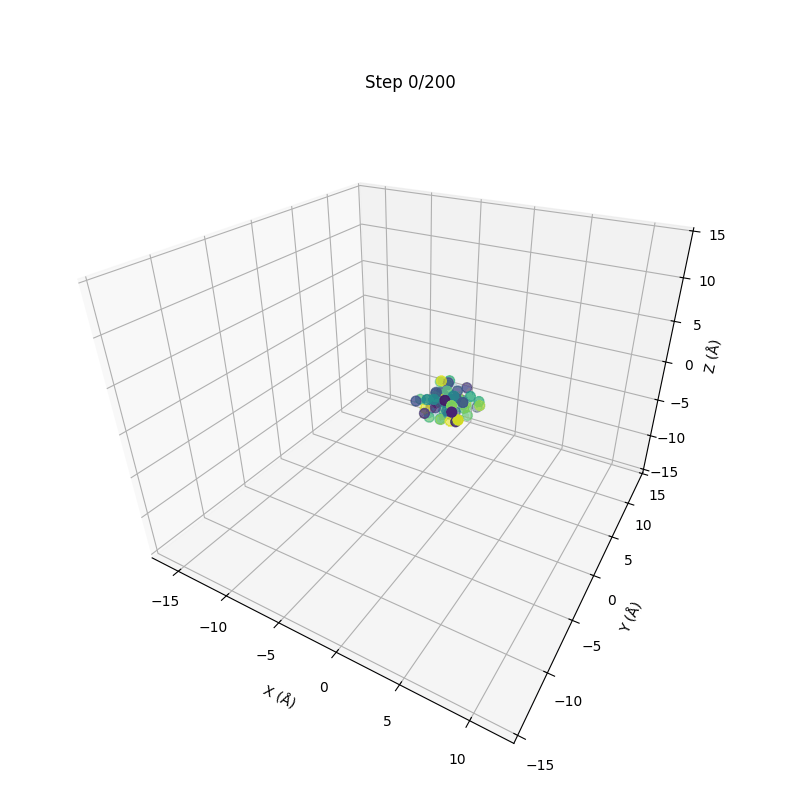

In [18]:
import glob
from IPython.display import Image, display

# Find the most recently generated trajectory
pattern = os.path.join(ROOT_DIR, MODEL_NAME, f'version_{MODEL_VERSION}', 'samples', '*', '*_traj.npy')
files = glob.glob(pattern)

if not files:
    print(f"No trajectory samples found in {pattern}. Please ensure the sampling step completed successfully with --save_trajectory.")
else:
    # Pick the most recent file based on creation time
    latest_traj = max(files, key=os.path.getctime)
    print(f"Visualizing trajectory: {latest_traj}")
    
    # Define output gif path
    output_gif = latest_traj.replace('.npy', '.gif')
    
    # Run visualization script to create GIF
    !python evaluations/visualize_trajectory.py "{latest_traj}" "{output_gif}"
    
    # Show the GIF
    if os.path.exists(output_gif):
        print(f"Displaying animation: {output_gif}")
        display(Image(filename=output_gif))
    else:
        print("Visualization script finished but GIF not found.")

## 6. 评估与分析 (Evaluation & Analysis)

我们提供工具来评估生成结构的创新性并分析其属性。
The repository provides tools to evaluate the novelty of generated structures and analyze their properties.

### 环境准备 (Environment Setup)

在运行评估管道之前，我们需要安装一些额外的依赖项，包括 ProteinMPNN（用于序列设计）、ESMFold（用于结构预测）以及 TM-score 工具。提供了一个脚本来自动完成这些设置。
Before running the evaluation pipeline, we need to install additional dependencies, including ProteinMPNN (for sequence design), ESMFold (for structure prediction), and TM-score tools. We provide a script to automate this setup.

In [ ]:
# Run setup script to install dependencies (ProteinMPNN, ESMFold, TM-tools)
!bash scripts/setup_evaluation_pipeline.sh

### 质量评估 (Quality Evaluation - scTM & pLDDT)

在分析结果之前，我们需要评估生成骨架的质量（可设计性）。评估流程使用 ProteinMPNN 进行序列设计，使用 ESMFold 进行结构预测，从而计算自洽 TM-score (scTM) 和 pLDDT。
Before analyzing the results, we need to evaluate the quality of the generated backbones (designability). The evaluation pipeline uses ProteinMPNN for sequence design and ESMFold for structure prediction to compute the self-consistency TM-score (scTM) and pLDDT.

此步骤生成后续绘图所需的 `info.csv` 文件。
This step generates the `info.csv` file needed for subsequent plots.

**命令行参数说明（`evaluations/pipeline/evaluate.py`）：**

- `--input_dir`（必选 / required）：包含待评估样本的目录。
- `--output_dir`（必选 / required）：评估结果输出目录（会生成 `info.csv` 等）。
- `-g, --gpus`（可选 / optional）：使用的 GPU 设备，例如 `"0"` 或 `"0,1"`。
- `-c, --config`（可选 / optional）：为兼容保留，但脚本会忽略该参数。

**注意：** 此步骤需要 GPU，并且根据样本数量可能需要一些时间。
**Note:** This step requires a GPU and may take some time depending on the number of samples.

In [ ]:
# To run the Quality Evaluation pipeline (ProteinMPNN + ESMFold):
!python evaluations/pipeline/evaluate.py --input_dir outputs/demo_samples --output_dir outputs/demo_samples/evaluations

### 创新性评估 (Novelty Evaluation)

这一部分的代码是我们新加入的。
你可以通过使用 TM-score 将生成的蛋白质与参考数据库（如 PDB）进行比较，来评估其“创新性”。
You can evaluate how "novel" your generated proteins are by comparing them against a reference database (e.g., PDB) using TM-score.

提供了两个脚本：
There are two provided scripts:

1. `evaluations/Novelty_Evaluation_CPU.py`: 穷举搜索（较慢，精确）。Exhaustive search (slower, exact).
2. `evaluations/Novelty_Evaluation_GPU.py`: 使用嵌入进行快速筛选的混合搜索（较快）。Hybrid search using embeddings for fast screening (faster).

**命令行参数说明（`evaluations/Novelty_Evaluation_CPU.py`）：**

- `-i, --input_dir`：输入目录（评估目录或 designs 目录；如存在 `designs/` 子目录会自动识别）。
- `-o, --output_csv`：输出 CSV 路径（默认 `<input_dir>/novelty.csv`）。
- `--ref_dir`：参考数据库目录（例如 `data/pdbstyle-2.08`）。
- `--tmalign`：TMalign 可执行文件路径。
- `--num_workers`：并行进程数。
- `--length_tolerance`：长度预筛选容差（默认 `0.3` 表示 ±30%）。
- `--early_stop_tm`：提前停止阈值（默认 `0.5`）。
- `--no_early_stop`：关闭提前停止，精确搜索最大 TM。
- `--no_length_filter`：关闭长度预筛选。

**命令行参数说明（`evaluations/Novelty_Evaluation_GPU.py`）：**

- `-i, --input_dir`：输入目录（包含 PDB 设计；若存在 `designs/` 子目录会自动切换到该子目录）。
- `-o, --output_csv`：输出 CSV 路径（默认生成 `novelty_hybrid.csv`）。
- `-r, --ref_dir`：参考数据库目录。

**使用示例 (生成命令):**
下面的单元格生成你将在终端运行的命令。注意，你需要安装参考数据库（例如 `data/pdbstyle-2.08`）才能使其工作。
The following cell generates the commands you would run in a terminal. Note that you need a reference database (e.g., `data/pdbstyle-2.08`) installed for these to work.

In [ ]:
# To run CPU-based Novelty Evaluation:
!python evaluations/Novelty_Evaluation_CPU.py --input_dir outputs/demo_samples/evaluations --ref_dir data/pdbstyle-2.08 --num_workers 4

# To run GPU-based Novelty Evaluation:
!python evaluations/Novelty_Evaluation_GPU.py --input_dir outputs/demo_samples/evaluations --ref_dir data/pdbstyle-2.08

### 分析绘图 (Analysis Plotting)

一旦你有了评估结果（例如来自评估流程的 `info.csv` 或来自上述脚本的 `novelty.csv/novelty_hybrid.csv`），你就可以生成分析图表。
Once you have evaluation results (e.g., `info.csv` from the evaluation pipeline or `novelty.csv/novelty_hybrid.csv` from the scripts above), you can generate analysis plots.

我们提供了一个统一的脚本 `evaluations/plot.py` 来处理所有绘图需求。
We provided a unified script `evaluations/plot.py` to handle all plotting needs.

**用法 (Usage):**
`python evaluations/plot.py -i <input_dir> -p <plot_type> -o <output_dir>`

**命令行参数说明（相当于 `--help`）：**

- `-i, --input_dir`：评估目录路径（至少包含 `info.csv`）。
- `-p, --plot`：图表类型（默认 `all`）。可选值：
  - `analysis`：综合分析（pLDDT vs scTM、SSE 分布、长度分布、统计柱状图）。
  - `mds`：设计空间 MDS 图（需要 `pair_info.csv`）。
  - `structures`：3D 结构示例（需要 PDB 设计文件与 novelty CSV）。
  - `all`：生成以上全部。
- `-o, --output_dir`：输出目录（默认当前目录）。

**Python API 参数说明（`evaluations/plot.py` 中的函数）：**

- `plot_genie_analysis(input_dir, output_file=...)`：
  - `input_dir`：评估目录。
  - `output_file`：输出图片路径。
- `plot_genie_mds_novelty(input_dir, output_file=...)`：
  - `input_dir`：评估目录（需要 `pair_info.csv`）。
  - `output_file`：输出图片路径。
- `plot_structures(input_dir, output_file=...)`：
  - `input_dir`：评估目录或 `designs/` 目录。
  - `output_file`：输出图片路径。

In [ ]:
# To generate ALL analysis plots (MDS, General Analysis, Structures):
!python evaluations/plot.py --input_dir outputs/demo_samples/evaluations --output_dir outputs/demo_samples/plots --plot all

# Or generate them individually:
# !python evaluations/plot.py -i outputs/demo_samples/evaluations -o outputs/demo_samples/plots -p mds
# !python evaluations/plot.py -i outputs/demo_samples/evaluations -o outputs/demo_samples/plots -p analysis
